In [74]:
import pandas as pd
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from numpy import interp

In [75]:
train_raw = pd.read_csv("train.csv")
test_raw = pd.read_csv("test.csv")
train = train_raw.drop(['Loan_ID'], axis = 1)
test = test_raw.drop(['Loan_ID'], axis = 1)


In [76]:
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [77]:
train.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [78]:
test.isnull().sum()

Gender               11
Married               0
Dependents           10
Education             0
Self_Employed        23
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
Property_Area         0
dtype: int64

In [79]:
for col in train:
    imr = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
    imr = imr.fit(train[[f'{col}']])
    train[f'{col}'] = imr.transform(train[[f'{col}']])
    
for col in test:
    imr = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
    imr = imr.fit(test[[f'{col}']])
    test[f'{col}'] = imr.transform(test[[f'{col}']])

In [80]:
le = LabelEncoder()
for col in train[['Gender', 'Married', 'Education','Self_Employed', 'Dependents', 'Property_Area','Credit_History', 'Loan_Status']]:  
    #print(col)
    train[col] = le.fit_transform(train[col])
#
# Print df.head for checking the transformation
#

train['CoapplicantIncome'] = train['CoapplicantIncome'].astype('int')
train.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,0,0,0,0,5849,0,120.0,360.0,1,2,1
1,1,1,1,0,0,4583,1508,128.0,360.0,1,0,0
2,1,1,0,0,1,3000,0,66.0,360.0,1,2,1
3,1,1,0,1,0,2583,2358,120.0,360.0,1,2,1
4,1,0,0,0,0,6000,0,141.0,360.0,1,2,1


In [81]:
le = LabelEncoder()
for col in test[['Gender', 'Married', 'Education','Self_Employed', 'Dependents','Credit_History', 'Property_Area']]:  
    #print(col)
    test[col] = le.fit_transform(test[col])
#
# Print df.head for checking the transformation
#
test['CoapplicantIncome'] = test['CoapplicantIncome'].astype('int')
test.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,1,1,0,0,0,5720,0,110.0,360.0,1,2
1,1,1,1,0,0,3076,1500,126.0,360.0,1,2
2,1,1,2,0,0,5000,1800,208.0,360.0,1,2
3,1,1,2,0,0,2340,2546,100.0,360.0,1,2
4,1,0,0,1,0,3276,0,78.0,360.0,1,2


In [82]:
train.dtypes

Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History         int64
Property_Area          int64
Loan_Status            int64
dtype: object

In [83]:
x = train.drop('Loan_Status', axis = 1)
y = train['Loan_Status']

In [84]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.4, stratify=y)

In [85]:
x_train.shape

(368, 11)

In [86]:
x_test.shape

(246, 11)

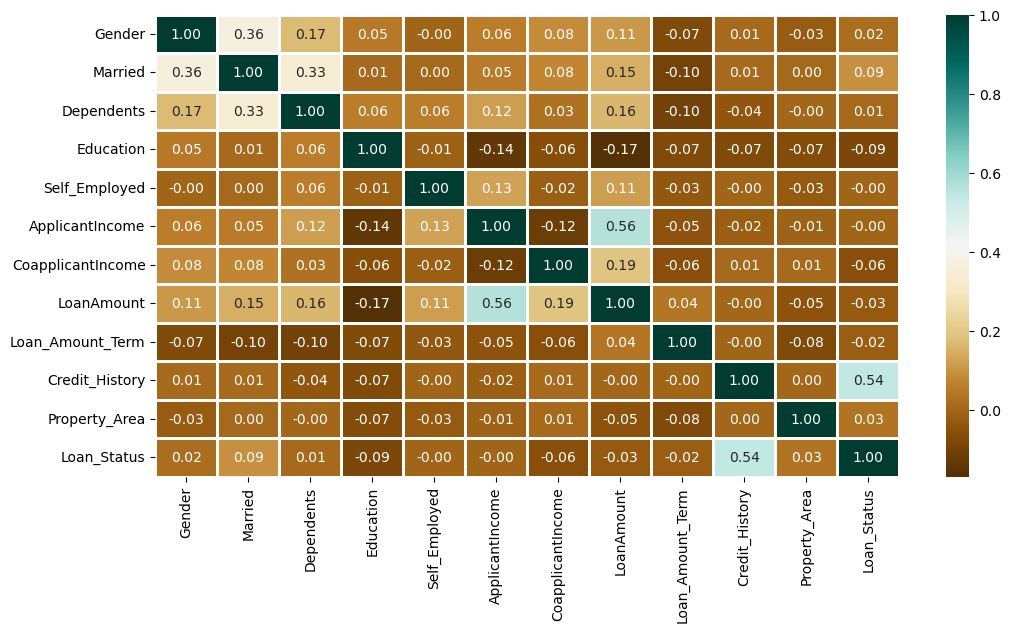

In [87]:
plt.figure(figsize=(12,6))

sns.heatmap(train.corr(),cmap='BrBG',fmt='.2f',
            linewidths=2,annot=True)
plt.savefig('korrelasjon.png')

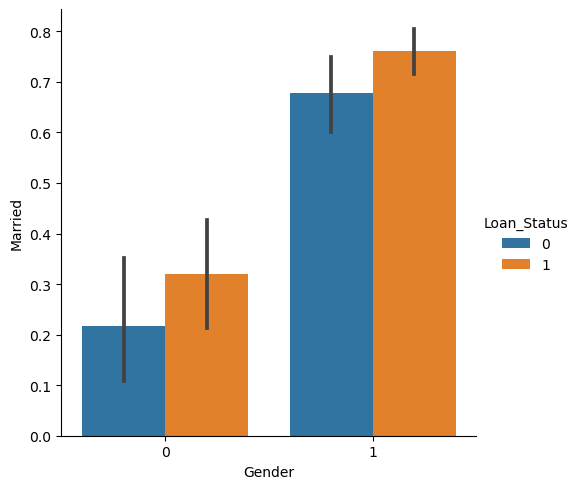

In [88]:
sns.catplot(x="Gender", y="Married",
            hue="Loan_Status",
            kind="bar",
            data=train)

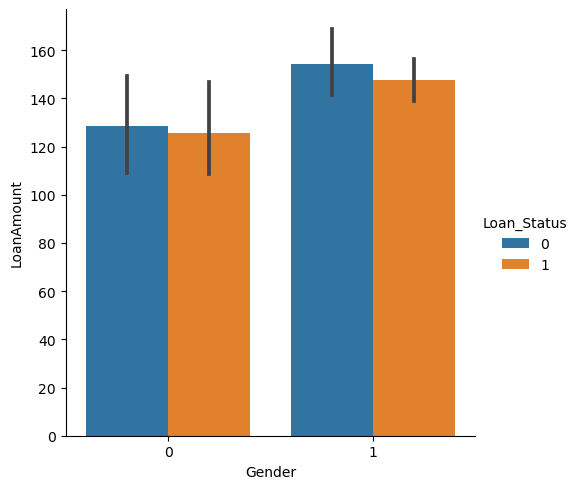

In [89]:
sns.catplot(y="LoanAmount", x="Gender",
            hue="Loan_Status",
            kind="bar",
            data=train)

In [47]:
log_clf = LogisticRegression()

param_grid = [{'C': [0.01, 0.05,0.1,0.5,1,10,100],
              'penalty':['l2', 'l1'],
               'max_iter': [10, 20, 50, 100, 150],
               'solver':['lbfgs', 'liblinear', 'sag', 'saga']}]
gs_r = GridSearchCV(log_clf,
                    param_grid,
                    scoring='f1',
                    cv=5,
                    verbose = 1,
                    n_jobs= -1)
gs_r.fit(x_train, y_train)
print(gs_r.best_score_)
print(gs_r.best_params_)


Fitting 5 folds for each of 280 candidates, totalling 1400 fits


/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

0.8761505147769564
{'C': 0.1, 'max_iter': 10, 'penalty': 'l1', 'solver': 'liblinear'}


/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-pack

In [90]:
# Random forest
# param_grid = {
#     'n_estimators': [50, 100, 150, 200, 300],
#     'max_features': ['auto', 'sqrt'],
#     'min_samples_leaf':[1,2,4],
#     'min_samples_split':[1,2,4],
#     'max_depth' : [3,4,5,6],
#     'criterion' :['gini', 'entropy']
# }
param_grid = {
        'n_estimators': [200, 300, 400, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [5, 6, 7, 8],
        'criterion': ['gini', 'entropy']
    }
rfc=RandomForestClassifier(random_state=42)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5,scoring='f1', n_jobs=-1, verbose=1)
CV_rfc.fit(x_train, y_train)
print(CV_rfc.best_score_)
print(CV_rfc.best_params_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits


/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=

0.8592021186850568
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'n_estimators': 200}


/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


In [102]:

ran=RandomForestClassifier(random_state=42,
                            max_features=CV_rfc.best_params_['max_features'],
                            n_estimators= CV_rfc.best_params_['n_estimators'],
                            max_depth=CV_rfc.best_params_['max_depth'],
                          # min_samples_split=CV_rfc.best_params_['min_samples_split'],
                          # min_samples_leaf=CV_rfc.best_params_['min_samples_leaf'],
                            criterion=CV_rfc.best_params_['criterion'])
ran.fit(x_train, y_train)

y_pred_test = CV_rfc.score(x_test, y_test)
prediction_test = CV_rfc.predict(x_test)

print("Accuracy for Random Forest (test data): ", y_pred_test)

/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy for Random Forest (test data):  0.8936170212765957


/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


 1) Credit_History                 0.415889
 2) LoanAmount                     0.146008
 3) ApplicantIncome                0.137724
 4) CoapplicantIncome              0.091970
 5) Loan_Amount_Term               0.053364
 6) Property_Area                  0.049454
 7) Dependents                     0.033232
 8) Married                        0.025676
 9) Education                      0.017827
10) Self_Employed                  0.016753
11) Gender                         0.012104


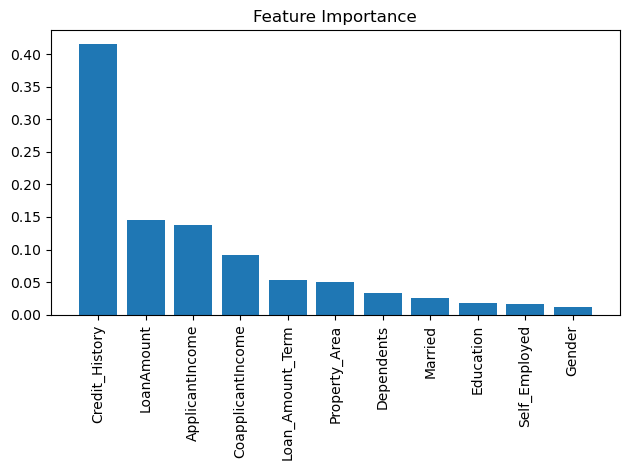

In [92]:
feat_labels = np.array(train.columns)

ran.fit(x_train, y_train)
importances = ran.feature_importances_

indices = np.argsort(importances)[::-1]

# Print results on screen
for f in range(x_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[indices[f]],
                            importances[indices[f]]))

plt.title('Feature Importance')
plt.bar(range(x_train.shape[1]),
        importances[indices],
        align='center')

plt.xticks(range(x_train.shape[1]),
           feat_labels[indices], rotation=90)
plt.xlim([-1, x_train.shape[1]])
plt.tight_layout()
plt.savefig('feature.png')
plt.show()

In [93]:
clf = gs_r.best_estimator_

In [94]:
gs_r.score(x_test, y_test)
prediction =  gs_r.predict(x_test)

In [95]:
model = clf.fit(x, y)
pred = model.predict(test)

/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


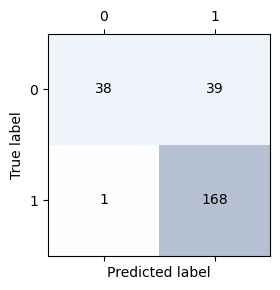

<Figure size 640x480 with 0 Axes>

In [105]:
# making a confusion matrix of a pipeline random forest
confmat = confusion_matrix(y_true=y_test, y_pred=prediction_test)

fig, ax = plt.subplots(figsize=(5, 3))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
plt.show()
plt.savefig('confusion_matrix.png')

/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/fbi/opt/anaconda3/envs/Tin100/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=

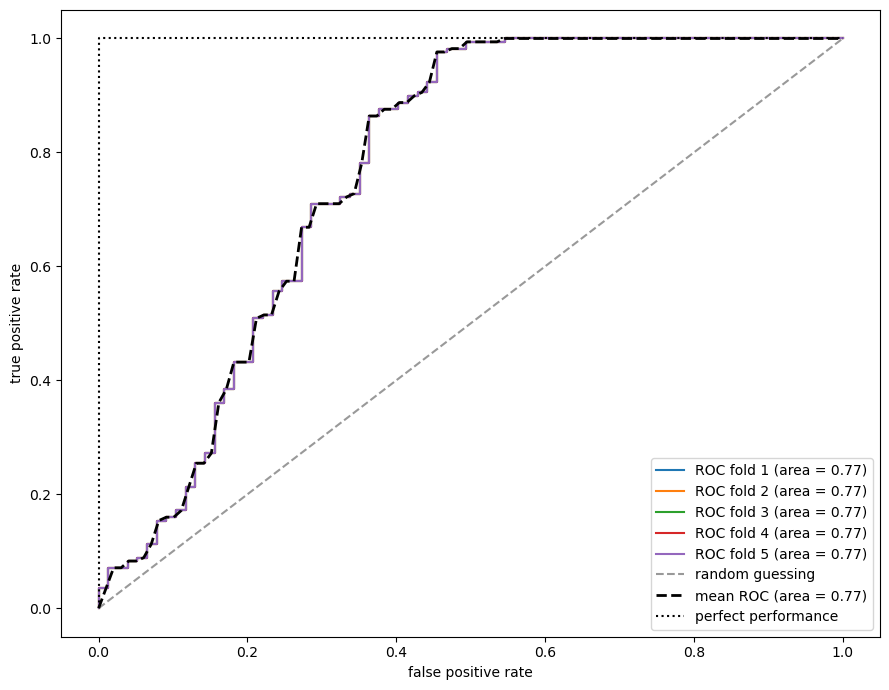

<Figure size 640x480 with 0 Axes>

In [106]:
 # Cross-validation specification
cv = list(StratifiedKFold(n_splits=5).split(x_train, y_train))

fig = plt.figure(figsize=(9, 7))

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

# Loop through folds of CV
for i, (train, test) in enumerate(cv):
    probas = ran.fit(x_train,
                    y_train).predict_proba(x_test) # Predict probability of classes

    # False Positive and True Positive Rates (thresholds for the decision function)
    fpr, tpr, thresholds = roc_curve(y_test,
                                     probas[:, 1],
                                     pos_label=1)
    # Add to mean True Predictive Rate in a smoothed variant (interpolated)
    mean_tpr += interp(mean_fpr, fpr, tpr)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,
             tpr,
             label='ROC fold %d (area = %0.2f)'
                   % (i+1, roc_auc))

plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6),
         label='random guessing')

# Average True Positive Rate
mean_tpr /= len(cv)
mean_tpr[0] = 0.0
mean_tpr[-1] = 1.0
# Average AUC
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='mean ROC (area = %0.2f)' % mean_auc, lw=2)
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()
plt.savefig('roc_curve.png')

In [ ]:
test['Loan_Status'] = pred

In [ ]:
New_loan_status = []
for i in range(len(test)):
    if test.iloc[i]['Loan_Status'] == 1:
        #print('hei')
        income = 5*12*(test.iloc[i]['ApplicantIncome'] + test.iloc[i]['CoapplicantIncome'])
        loan = (test.iloc[i]['LoanAmount'])*1000
        New_loan_status.append(income > loan)
    else:
        New_loan_status.append(0)

In [ ]:
test['new_loan_status'] = New_loan_status

In [ ]:
test.head(49)

In [ ]:
df = test['Loan_Status']
df.value_counts()

In [ ]:
df = test['new_loan_status']
df.value_counts()